In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn.metrics import r2_score
import plotly.graph_objs as go
import plotly.offline as pyoff
from sklearn.model_selection import train_test_split as tts

In [2]:
center_info = pd.read_csv('fulfilment_center_info.csv')
meal_info = pd.read_csv('meal_info.csv')
test_data = pd.read_csv('genpact_test.csv')
train_data = pd.read_csv('genpact_train.csv')

In [3]:
df = pd.merge(pd.merge(train_data, center_info, on='center_id'), meal_info, on='meal_id')
test = pd.merge(pd.merge(test_data, center_info, on='center_id'), meal_info, on='meal_id')

In [4]:
df_=df.copy()

In [5]:
cat_var = ['center_type','category','cuisine']

In [6]:
#encoding
for i in cat_var:
    df_[i] = pd.factorize(df_[i])[0]

In [7]:
df_

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,0,2.0,0,0
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,0,2.0,0,0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,0,2.0,0,0
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,0,2.0,0,1
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,0,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,473,77,2,4.5,10,1
456544,1062036,145,61,2304,482.09,482.09,0,0,42,473,77,2,4.5,10,1
456545,1110849,145,61,2664,237.68,321.07,0,0,501,473,77,2,4.5,12,2
456546,1147725,145,61,2569,243.50,313.34,0,0,729,473,77,2,4.5,12,2


<Figure size 1200x900 with 0 Axes>

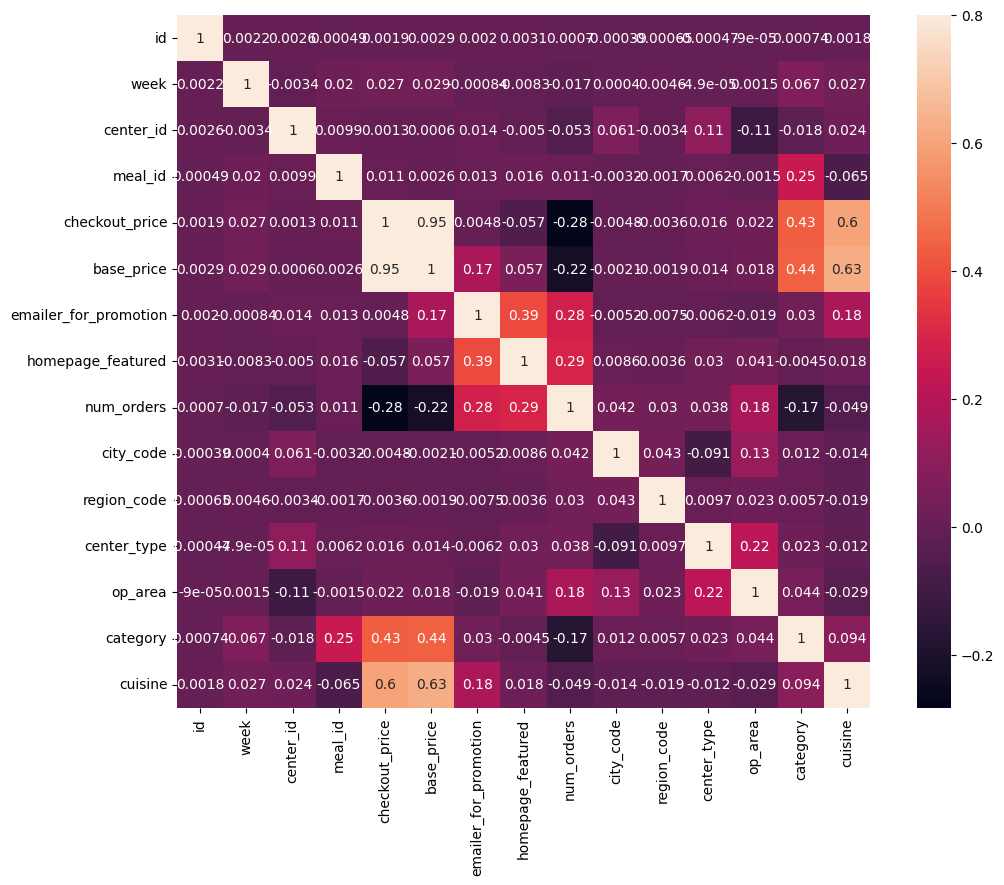

In [8]:
plt.figure(figsize=(12,9))
fig = plt.figure(figsize = (12, 9))
sns.heatmap(df_.corr(), vmax = .8, square = True, annot = True)
plt.show()

In [9]:
X = df_.drop(['num_orders'], axis=1).values
y = df_['num_orders'].values
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=0)

In [10]:
df_.shape

(456548, 15)

In [11]:
timesteps = 7
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
X_train_reshaped = X_train.reshape((n_samples, timesteps, n_features // timesteps))
print(X_train_reshaped.shape)
X_test_reshaped = X_test.reshape((X_test.shape[0], timesteps, X_test.shape[1] // timesteps))
print(X_test_reshaped.shape)

(365238, 7, 2)
(91310, 7, 2)


In [12]:
model = Sequential()
model.add(LSTM(100, input_shape=(timesteps, n_features // timesteps)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               41200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4566/4566 [==============================] - 23s 4ms/step - loss: 168908.2500 - val_loss: 161558.4062
Epoch 2/10
4566/4566 [==============================] - 18s 4ms/step - loss: 132285.3438 - val_loss: 128357.5859
Epoch 3/10
4566/4566 [==============================] - 19s 4ms/step - loss: 113033.5234 - val_loss: 113543.7344
Epoch 4/10
4566/4566 [==============================] - 18s 4ms/step - loss: 101875.1641 - val_loss: 104014.3

In [13]:
test_loss = model.evaluate(X_test_reshaped, y_test)
predictions = model.predict(X_test_reshaped)

2854/2854 [==============================] - 4s 1ms/step


In [14]:
r2_score(y_test, predictions)

0.5327224731445312

In [15]:
BiLstm = Sequential()
BiLstm.add(Bidirectional(LSTM(units=64, return_sequences=True),  input_shape=(timesteps, n_features // timesteps)))
BiLstm.add(Bidirectional(LSTM(units=32, return_sequences=True)))
BiLstm.add(LSTM(units=16))
BiLstm.add(Dense(1))
BiLstm.compile(loss='mean_squared_error', optimizer='adam')
BiLstm.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2)
y_pred_Bi_lstm = BiLstm.predict(X_test_reshaped)

Epoch 1/10
4566/4566 [==============================] - 54s 11ms/step - loss: 205023.5000 - val_loss: 199282.7344
Epoch 2/10
4566/4566 [==============================] - 48s 11ms/step - loss: 179043.1406 - val_loss: 178881.4531
Epoch 3/10
4566/4566 [==============================] - 48s 10ms/step - loss: 163823.0625 - val_loss: 168433.3750
Epoch 4/10
4566/4566 [==============================] - 48s 11ms/step - loss: 157494.7500 - val_loss: 165387.1250
Epoch 5/10
4566/4566 [==============================] - 48s 11ms/step - loss: 156199.0938 - val_loss: 165054.1250
Epoch 6/10
4566/4566 [==============================] - 49s 11ms/step - loss: 152661.7812 - val_loss: 145911.1094
Epoch 7/10
4566/4566 [==============================] - 49s 11ms/step - loss: 128992.5703 - val_loss: 132510.3750
Epoch 8/10
4566/4566 [==============================] - 49s 11ms/step - loss: 119088.7188 - val_loss: 123690.8516
Epoch 9/10
4566/4566 [==============================] - 49s 11ms/step - loss: 111296.906

In [ ]:
bilstm_model = Sequential([Input(shape=(timesteps, n_features // timesteps)),
    Bidirectional(LSTM(unit_size, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(unit_size)),
    Dense(1)
])
bilstm_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
bilstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)
y_pred_bilstm = bilstm_model.predict(X_test_reshaped)
r2_bilstm = compute_metrics(y_test, y_pred_bilstm, "Bi-LSTM Model")


In [16]:
r2_score(y_test, y_pred_Bi_lstm)

0.3540465235710144

In [17]:
Sta_Lstm = Sequential()
Sta_Lstm.add(LSTM(units=64, return_sequences=True, input_shape=(timesteps, n_features // timesteps)))
Sta_Lstm.add(LSTM(units=32, return_sequences=True)) 
Sta_Lstm.add(LSTM(units=16))
Sta_Lstm.add(Dense(1))
Sta_Lstm.compile(loss='mean_squared_error', optimizer='adam')
Sta_Lstm.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_split=0.2)
y_pred_stac_lstm= Sta_Lstm.predict(X_test_reshaped)

Epoch 1/20
4566/4566 [==============================] - 47s 9ms/step - loss: 204761.4062 - val_loss: 199071.7188
Epoch 2/20
4566/4566 [==============================] - 34s 7ms/step - loss: 178909.3438 - val_loss: 178799.8438
Epoch 3/20
4566/4566 [==============================] - 34s 7ms/step - loss: 163765.8906 - val_loss: 168410.1406
Epoch 4/20
4566/4566 [==============================] - 34s 7ms/step - loss: 157473.2344 - val_loss: 165371.2344
Epoch 5/20
4566/4566 [==============================] - 33s 7ms/step - loss: 156187.3906 - val_loss: 165047.0156
Epoch 6/20
4566/4566 [==============================] - 33s 7ms/step - loss: 156090.9844 - val_loss: 165029.9375
Epoch 7/20
4566/4566 [==============================] - 32s 7ms/step - loss: 156086.6719 - val_loss: 165029.2500
Epoch 8/20
4566/4566 [==============================] - 34s 7ms/step - loss: 156086.8594 - val_loss: 165028.7344
Epoch 9/20
4566/4566 [==============================] - 41s 9ms/step - loss: 156086.3125 - val_l

In [18]:
r2_score(y_test, y_pred_stac_lstm)

-2.6226043701171875e-06

In [ ]:
test1=test.copy()

In [ ]:
for i in cat_var:
    test[i] = pd.factorize(test[i])[0]

In [ ]:
test_pred=test.values

In [ ]:
timesteps = 7
n_samples = test_pred.shape[0]
n_features = test_pred.shape[1]
test_reshaped = test_pred.reshape((n_samples, timesteps, n_features // timesteps))

In [ ]:
ypred=model.predict(test_reshaped)

In [ ]:
ts_tot_orders = df.groupby(['week'])['num_orders'].sum()
ts_tot_orders = pd.DataFrame(ts_tot_orders)
ts_tot_orders

In [ ]:
ypred_df = pd.DataFrame(ypred, columns=['predicted_orders'])  # Give a meaningful name

In [ ]:
# Reset index of test to avoid duplicate index issues during merge
test_reset = test.reset_index(drop=True)

In [ ]:
# Merge predictions with test data to get category information
predictions = pd.concat([test_reset, ypred_df], axis=1)

In [ ]:
# Group by week and category, then sum the orders
ts_cat_pred = predictions.groupby(['week', 'category'])['predicted_orders'].sum().reset_index()
ts_cat_actual = df.groupby(['week', 'category'])['num_orders'].sum().reset_index()

In [ ]:
# Plotly visualization for each category
categories = ts_cat_actual['category'].unique()  # Get unique categories

In [ ]:
for category in categories:
    # Filter data for the current category
    actual_data = ts_cat_actual[ts_cat_actual['category'] == category]
    predicted_data = ts_cat_pred[ts_cat_pred['category'] == category]

    # Ensure both DataFrames have the same 'week' values for proper alignment
    merged_data = pd.merge(actual_data, predicted_data, on='week', how='outer')

    plot_data = [
        go.Scatter(
            x=merged_data['week'],  # Use the merged 'week' values
            y=merged_data['num_orders'],
            name=f'Actual - {category}',
            marker=dict(color='Blue')
        ),
        go.Scatter(
            x=merged_data['week'],  # Use the merged 'week' values
            y=merged_data['predicted_orders'],
            name=f'Predicted - {category}',
            marker=dict(color='Red')
        )
    ]

    plot_layout = go.Layout(
        title=f'Total orders per week - Category: {category}',
        yaxis_title='Total orders',
        xaxis_title='Week',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)

In [ ]:
ts_tot_pred = predictions.groupby(['week'])['num_orders'].sum()
ts_tot_pred = pd.DataFrame(ts_tot_pred)

In [ ]:

plot_data = [
    go.Scatter(
        x=ts_tot_orders.index,y=ts_tot_orders['num_orders'],name='Time Series for num_orders',marker = dict(color = 'Blue')#x_axis="OTI",#y_axis="time",
    ),
    go.Scatter(
        x=ts_tot_pred.index,y=ts_tot_pred['num_orders'],name='Predicted',marker = dict(color = 'Red')#x_axis="OTI",#y_axis="time",
    )
    
]
plot_layout = go.Layout(
        title='Total orders per week',yaxis_title='Total orders',xaxis_title='Week',plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import plotly.graph_objs as go
import plotly.offline as pyoff

# Load data
center_info = pd.read_csv('fulfilment_center_info.csv')
meal_info = pd.read_csv('meal_info.csv')
test_data = pd.read_csv('genpact_test.csv')
train_data = pd.read_csv('genpact_train.csv')

# Merge data
df = pd.merge(pd.merge(train_data, center_info, on='center_id'), meal_info, on='meal_id')
test = pd.merge(pd.merge(test_data, center_info, on='center_id'), meal_info, on='meal_id')

df_ = df.copy()
cat_var = ['center_type', 'category', 'cuisine']

# Encoding categorical variables
for col in cat_var:
    df_[col] = pd.factorize(df_[col])[0]
    test[col] = pd.factorize(test[col])[0]

# Correlation heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(df_.corr(), vmax=0.8, square=True, annot=True)
plt.show()

# Prepare data for training
X = df_.drop(['num_orders'], axis=1).values
y = df_['num_orders'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

timesteps = 7
n_features = X_train.shape[1]

# Reshape data for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], timesteps, n_features // timesteps))
X_test_reshaped = X_test.reshape((X_test.shape[0], timesteps, n_features // timesteps))

# Define model
model = Sequential([
    LSTM(50, input_shape=(timesteps, n_features // timesteps)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate model
y_pred = model.predict(X_test_reshaped)
print("R2 Score:", r2_score(y_test, y_pred))

# Prepare test data for prediction
test_values = test.values
test_reshaped = test_values.reshape((test_values.shape[0], timesteps, test_values.shape[1] // timesteps))
ypred = model.predict(test_reshaped)

# Create DataFrame for predictions
ypred_df = pd.DataFrame(ypred, columns=['predicted_orders'])
test_reset = test.reset_index(drop=True)
predictions = pd.concat([test_reset, ypred_df], axis=1)

# Aggregate predictions by week & category
ts_cat_pred = predictions.groupby(['week', 'category'])['predicted_orders'].sum().reset_index()
ts_cat_actual = df.groupby(['week', 'category'])['num_orders'].sum().reset_index()

# Ensure 'week' column data types match
ts_cat_actual['week'] = ts_cat_actual['week'].astype(str)
ts_cat_pred['week'] = ts_cat_pred['week'].astype(str)

# Plot category-wise forecast
categories = ts_cat_actual['category'].unique()
for category in categories:
    actual_data = ts_cat_actual[ts_cat_actual['category'] == category]
    predicted_data = ts_cat_pred[ts_cat_pred['category'] == category]
    
    # Ensure proper merging
    merged_data = pd.merge(actual_data, predicted_data, on=['week', 'category'], how='inner')
    
    plot_data = [
        go.Scatter(x=merged_data['week'], y=merged_data['num_orders'], name=f'Actual - {category}', marker=dict(color='Blue')),
        go.Scatter(x=merged_data['week'], y=merged_data['predicted_orders'], name=f'Predicted - {category}', marker=dict(color='Red'))
    ]
    
    plot_layout = go.Layout(title=f'Total orders per week - Category: {category}', yaxis_title='Total orders', xaxis_title='Week')
    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)

# Aggregate total orders per week
ts_tot_orders = df.groupby('week')['num_orders'].sum().reset_index()
ts_tot_pred = predictions.groupby('week')['predicted_orders'].sum().reset_index()

# Ensure correct indexing
ts_tot_orders['week'] = ts_tot_orders['week'].astype(str)
ts_tot_pred['week'] = ts_tot_pred['week'].astype(str)

# Merge total orders data
merged_tot = pd.merge(ts_tot_orders, ts_tot_pred, on='week', how='inner')

# Plot total orders forecast
plot_data = [
    go.Scatter(x=merged_tot['week'], y=merged_tot['num_orders'], name='Actual', marker=dict(color='Blue')),
    go.Scatter(x=merged_tot['week'], y=merged_tot['predicted_orders'], name='Predicted', marker=dict(color='Red'))
]
plot_layout = go.Layout(title='Total orders per week', yaxis_title='Total orders', xaxis_title='Week')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [ ]:
print(ts_cat_pred)

In [ ]:
print("Unique weeks in actual data:", ts_cat_actual['week'].unique())
print("Unique weeks in predicted data:", ts_cat_pred['week'].unique())

print("Unique categories in actual data:", ts_cat_actual['category'].unique())
print("Unique categories in predicted data:", ts_cat_pred['category'].unique())


In [22]:
print(df['category'].unique())

['Beverages' 'Rice Bowl' 'Starters' 'Pasta' 'Sandwich' 'Biryani' 'Extras'
 'Pizza' 'Seafood' 'Other Snacks' 'Desert' 'Soup' 'Salad' 'Fish']
